In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs
    
import statsmodels.api as sm
from scipy import stats

from scsavailability import features as feat, model as md, results as rs

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

path = 'C:/Users/Jamie.williams/OneDrive - Newton Europe Ltd/Castle Donnington/Data/'

at = pd.read_csv(path+'active_totes_20201210.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-0912.csv',names = ["timestamp","Pick Station","Availability","Blue Tote Loss","Grey Tote Loss"])
#fa = pd.read_csv(path + 'scs_tote_matched.csv')
scs_raw = pd.read_csv(path + 'Faults20_11-10_12.csv')

at = feat.pre_process_AT(at)
av = feat.pre_process_av(av)
fa,unmapped, end_time = feat.preprocess_faults(scs_raw)

Output,R2 = rs.run_single_model(at,av,fa,end_time,shift=0,weights=[1],speed=470,picker_present=0.91,availability=0.71)

Running: Function "pre_process_AT" (id=2771265698256) was called 1 times
Running: Function "pre_process_av" (id=2771265698976) was called 1 times
Running: Function "preprocess_faults" (id=2771265699552) was called 1 times
Running: Function "load_tote_lookup" (id=2771265699696) was called 1 times
Running: Function "load_module_lookup" (id=2771262733472) was called 1 times
Running: Function "load_ID_lookup" (id=2771265696528) was called 1 times
duplicated location faults removed - max duration kept
Running: Function "run_single_model" (id=2771267449472) was called 1 times
Running: Function "floor_shift_time_fa" (id=2771265697968) was called 1 times
Running: Function "create_PTT_df" (id=2771265775360) was called 1 times
Running: Function "fault_select" (id=2771265698400) was called 1 times
Running: Function "load_PTT_lookup" (id=2771265698544) was called 1 times
Running: Function "faults_aggregate" (id=2771265773632) was called 1 times
Running: Function "weight_hours" (id=2771265774784) w

Running: Function "aggregate_availability" (id=2771265774208) was called 13 times
Running: Function "aggregate_totes" (id=2771265774496) was called 13 times
Running: Function "merge_av_fa_at" (id=2771265775072) was called 13 times
Running: Function "fault_select" (id=2771265698400) was called 14 times
Running: Function "load_PTT_lookup" (id=2771265698544) was called 14 times
Running: Function "faults_aggregate" (id=2771265773632) was called 14 times
Running: Function "weight_hours" (id=2771265774784) was called 14 times
Running: Function "av_at_select" (id=2771265773920) was called 14 times
Running: Function "aggregate_availability" (id=2771265774208) was called 14 times
Running: Function "aggregate_totes" (id=2771265774496) was called 14 times
Running: Function "merge_av_fa_at" (id=2771265775072) was called 14 times
Running: Function "fault_select" (id=2771265698400) was called 15 times
Running: Function "load_PTT_lookup" (id=2771265698544) was called 15 times
Running: Function "fault

Running: Function "av_at_select" (id=2771265773920) was called 27 times
Running: Function "aggregate_availability" (id=2771265774208) was called 27 times
Running: Function "aggregate_totes" (id=2771265774496) was called 27 times
Running: Function "merge_av_fa_at" (id=2771265775072) was called 27 times
Running: Function "fault_select" (id=2771265698400) was called 28 times
Running: Function "load_PTT_lookup" (id=2771265698544) was called 28 times
Running: Function "faults_aggregate" (id=2771265773632) was called 28 times
Running: Function "weight_hours" (id=2771265774784) was called 28 times
Running: Function "av_at_select" (id=2771265773920) was called 28 times
Running: Function "aggregate_availability" (id=2771265774208) was called 28 times
Running: Function "aggregate_totes" (id=2771265774496) was called 28 times
Running: Function "merge_av_fa_at" (id=2771265775072) was called 28 times
Running: Function "fault_select" (id=2771265698400) was called 29 times
Running: Function "load_PTT

C:\Users\Jamie.williams\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


['C05', 'C0501ACH011', 'C0501RDC004', 'C0501STA002', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0501STA230', 'C0502ACH023', 'C0502ACH033', 'C0502ACH043', 'C0502ACH055', 'C0502ACH079', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502RDC040', 'C0502STA024', 'C0502STA026', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA044', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA058', 'C0502STA059', 'C0502STA060', 'C0502STA068', 'C0502STA071', 'C0502STA072', 'C0502STA073', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA089', 'C0502STA091', 'C0502STA097', 'C0503ACH223', 'C0503ACH233', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C0503STA252', 'C05PTT011', 'C0601ACH018', 'C0601STA020', 'C0601STA201', 'C0603ACH111', 'C0603STA102', 'C0603STA120', 'C0701ACH011', 'C0701ACH018', 'C0701STA002', 'C0701STA020', 'C0703ACH101', 'C0703ACH111', 'C07

['C05', 'C0501ACH011', 'C0501RDC004', 'C0501STA002', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0501STA230', 'C0502ACH023', 'C0502ACH033', 'C0502ACH043', 'C0502ACH055', 'C0502ACH079', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502RDC040', 'C0502STA024', 'C0502STA026', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA044', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA058', 'C0502STA059', 'C0502STA060', 'C0502STA068', 'C0502STA072', 'C0502STA073', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0502STA097', 'C0503ACH223', 'C0503ACH233', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C0503STA252', 'C05PTT011', 'C0601ACH018', 'C0601STA020', 'C0601STA201', 'C0603ACH111', 'C0603STA102', 'C0603STA120', 'C0701ACH011', 'C0701ACH018', 'C0701STA002', 'C0701STA020', 'C0703ACH101', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C07

['C05', 'C0501ACH011', 'C0501RDC004', 'C0501STA002', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0501STA230', 'C0502ACH023', 'C0502ACH033', 'C0502ACH043', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502RDC040', 'C0502STA024', 'C0502STA026', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA044', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA058', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA073', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0502STA097', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C0503STA252', 'C05PTT011', 'C0601ACH018', 'C0601STA020', 'C0601STA201', 'C0603ACH111', 'C0603STA102', 'C0603STA120', 'C0701ACH011', 'C0701ACH018', 'C0701STA002', 'C0701STA020', 'C0703ACH101', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0703STA115', 'C0704STA201', 'C0704STA206', 'C15

['C05', 'C0501ACH011', 'C0501RDC004', 'C0501STA002', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH023', 'C0502ACH033', 'C0502ACH043', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502RDC040', 'C0502STA024', 'C0502STA026', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA058', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA073', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0502STA097', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C0503STA252', 'C05PTT011', 'C0601ACH018', 'C0601STA020', 'C0601STA201', 'C0603ACH111', 'C0701ACH011', 'C0701ACH018', 'C0701STA002', 'C0701STA020', 'C0703ACH101', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0703STA115', 'C0704STA201', 'C0704STA206', 'C1501ACH217', 'C1501ACH234', 'C1501BCL085', 'C1501BCL223', 'C15

['C05', 'C0501ACH011', 'C0501RDC004', 'C0501STA002', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH023', 'C0502ACH033', 'C0502ACH043', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502RDC040', 'C0502STA024', 'C0502STA026', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA058', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA073', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0502STA097', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C0503STA252', 'C05PTT011', 'C0601ACH018', 'C0601STA020', 'C0601STA201', 'C0603ACH111', 'C0701ACH011', 'C0701ACH018', 'C0701STA002', 'C0701STA020', 'C0703ACH101', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0703STA115', 'C0704STA201', 'C0704STA206', 'C1501ACH217', 'C1501ACH234', 'C1501BCL085', 'C1501BCL223', 'C15

['C05', 'C0501ACH011', 'C0501RDC004', 'C0501STA002', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH023', 'C0502ACH033', 'C0502ACH043', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502RDC040', 'C0502STA024', 'C0502STA026', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA058', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C0503STA252', 'C05PTT011', 'C0601ACH018', 'C0601STA020', 'C0601STA201', 'C0603ACH111', 'C0701ACH011', 'C0701STA002', 'C0701STA020', 'C0703ACH101', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0703STA115', 'C0704STA201', 'C0704STA206', 'C1501ACH217', 'C1501ACH234', 'C1501BCL085', 'C1501BCL223', 'C1501BCL231', 'C1501RDC001', 'C1501RDC218', 'C15

['C05', 'C0501ACH011', 'C0501RDC004', 'C0501STA002', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH023', 'C0502ACH033', 'C0502ACH043', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502RDC040', 'C0502STA024', 'C0502STA026', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA058', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C0503STA252', 'C05PTT011', 'C0601ACH018', 'C0601STA020', 'C0601STA201', 'C0603ACH111', 'C0701ACH011', 'C0701STA002', 'C0701STA020', 'C0703ACH101', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0703STA115', 'C0704STA201', 'C0704STA206', 'C1501ACH217', 'C1501ACH234', 'C1501BCL085', 'C1501BCL223', 'C1501BCL231', 'C1501RDC001', 'C1501RDC218', 'C15

['C05', 'C0501RDC004', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH023', 'C0502ACH033', 'C0502ACH043', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502RDC040', 'C0502STA024', 'C0502STA026', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA058', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C05PTT011', 'C0601ACH018', 'C0601STA020', 'C0601STA201', 'C0603ACH111', 'C0701ACH011', 'C0701STA002', 'C0701STA020', 'C0703ACH101', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0703STA115', 'C0704STA201', 'C0704STA206', 'C1501ACH234', 'C1501BCL085', 'C1501BCL223', 'C1501BCL231', 'C1501RDC001', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA211', 'C1501STA214', 'C15

['C05', 'C0501RDC004', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH023', 'C0502ACH033', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA026', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA058', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C05PTT011', 'C0601ACH018', 'C0601STA020', 'C0601STA201', 'C0603ACH111', 'C0701ACH011', 'C0701STA002', 'C0701STA020', 'C0703ACH101', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0703STA115', 'C0704STA201', 'C1501ACH234', 'C1501BCL085', 'C1501BCL223', 'C1501BCL231', 'C1501RDC001', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA211', 'C1501STA214', 'C1501STA215', 'C1501STA221', 'C1502ACH004', 'C1502ACH005', 'C15

['C05', 'C0501RDC004', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH023', 'C0502ACH033', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C05PTT011', 'C0601ACH018', 'C0601STA020', 'C0601STA201', 'C0603ACH111', 'C0701STA002', 'C0701STA020', 'C0703ACH101', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0703STA115', 'C0704STA201', 'C1501ACH234', 'C1501BCL085', 'C1501BCL223', 'C1501BCL231', 'C1501RDC001', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA211', 'C1501STA221', 'C1502ACH004', 'C1502ACH005', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C15

['C05', 'C0501RDC004', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH023', 'C0502ACH033', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C05PTT011', 'C0601ACH018', 'C0601STA201', 'C0603ACH111', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0704STA201', 'C1501ACH234', 'C1501BCL085', 'C1501BCL223', 'C1501BCL231', 'C1501RDC001', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA211', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC013', 'C1502RDC035', 'C1502RDC053', 'C15

['C05', 'C0501RDC004', 'C0501STA012', 'C0501STA020', 'C0501STA201', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH023', 'C0502ACH033', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C0503STA251', 'C05PTT011', 'C0601ACH018', 'C0601STA201', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0704STA201', 'C1501ACH234', 'C1501BCL085', 'C1501BCL223', 'C1501BCL231', 'C1501RDC001', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC013', 'C1502RDC035', 'C1502RDC053', 'C1502RDC064', 'C1502RDC070', 'C15

['C05', 'C0501RDC004', 'C0501STA012', 'C0501STA020', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH023', 'C0502ACH033', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA032', 'C0502STA039', 'C0502STA041', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C05PTT011', 'C0601ACH018', 'C0601STA201', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0704STA201', 'C1501ACH234', 'C1501BCL085', 'C1501BCL223', 'C1501BCL231', 'C1501RDC001', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC013', 'C1502RDC035', 'C1502RDC053', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C15

['C05', 'C0501RDC004', 'C0501STA012', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH033', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA041', 'C0502STA051', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C0503STA226', 'C05PTT011', 'C0601ACH018', 'C0601STA201', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0704STA201', 'C1501ACH234', 'C1501BCL085', 'C1501BCL223', 'C1501BCL231', 'C1501RDC001', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC013', 'C1502RDC035', 'C1502RDC053', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502RDC247', 'C1502STA006', 'C1502STA034', 'C1502STA038', 'C15

['C05', 'C0501RDC004', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH033', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA041', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C05PTT011', 'C0601ACH018', 'C0601STA201', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0704STA201', 'C1501ACH234', 'C1501BCL085', 'C1501BCL231', 'C1501RDC001', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC013', 'C1502RDC035', 'C1502RDC053', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502RDC247', 'C1502STA006', 'C1502STA034', 'C1502STA038', 'C1502STA046', 'C1502STA063', 'C1502STA074', 'C1502STA238', 'C15

['C05', 'C0501RDC004', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH033', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA041', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C05PTT011', 'C0601ACH018', 'C0601STA201', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0704STA201', 'C1501ACH234', 'C1501BCL085', 'C1501BCL231', 'C1501RDC001', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC013', 'C1502RDC035', 'C1502RDC053', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502RDC247', 'C1502STA034', 'C1502STA038', 'C1502STA046', 'C1502STA063', 'C1502STA074', 'C1502STA238', 'C1502STA241', 'C15

['C05', 'C0501RDC004', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA041', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA060', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0502STA091', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C05PTT011', 'C0601ACH018', 'C0601STA201', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0704STA201', 'C1501ACH234', 'C1501BCL085', 'C1501BCL231', 'C1501RDC001', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC013', 'C1502RDC035', 'C1502RDC053', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502RDC247', 'C1502STA034', 'C1502STA038', 'C1502STA046', 'C1502STA063', 'C1502STA074', 'C1502STA238', 'C1502STA241', 'C1502STA245', 'C15

['C05', 'C0501STA217', 'C0501STA219', 'C0501STA228', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA041', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C05PTT011', 'C0601ACH018', 'C0601STA201', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0704STA201', 'C1501ACH234', 'C1501BCL085', 'C1501BCL231', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC013', 'C1502RDC035', 'C1502RDC053', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502RDC247', 'C1502STA034', 'C1502STA038', 'C1502STA046', 'C1502STA063', 'C1502STA074', 'C1502STA238', 'C1502STA241', 'C1502STA245', 'C1502STA246', 'C1603ACH017', 'C1603ACH100', 'C1603ACL019', 'C16

['C05', 'C0501STA217', 'C0501STA228', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA041', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C05PTT011', 'C0601ACH018', 'C0601STA201', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C0704STA201', 'C1501ACH234', 'C1501BCL085', 'C1501BCL231', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC013', 'C1502RDC035', 'C1502RDC053', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502RDC247', 'C1502STA034', 'C1502STA038', 'C1502STA046', 'C1502STA063', 'C1502STA074', 'C1502STA238', 'C1502STA241', 'C1502STA245', 'C1603ACH100', 'C1603ACL019', 'C1603ACL142', 'C1603BCH101', 'C1603BCL015', 'C16

['C05', 'C0501STA217', 'C0501STA228', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA041', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C05PTT011', 'C0601ACH018', 'C0601STA201', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C0703ACH114', 'C0703STA102', 'C1501ACH234', 'C1501BCL085', 'C1501BCL231', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC013', 'C1502RDC035', 'C1502RDC053', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502RDC247', 'C1502STA034', 'C1502STA038', 'C1502STA046', 'C1502STA063', 'C1502STA074', 'C1502STA238', 'C1502STA241', 'C1502STA245', 'C1603ACH100', 'C1603ACL019', 'C1603ACL142', 'C1603BCH101', 'C1603BCL015', 'C1603BCL018', 'C16

['C05', 'C0501STA217', 'C0501STA228', 'C0502ACH055', 'C0502ACL090', 'C0502RDC036', 'C0502RDC038', 'C0502STA030', 'C0502STA041', 'C0502STA056', 'C0502STA057', 'C0502STA059', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0502STA087', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C05PTT011', 'C0601ACH018', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C1501ACH234', 'C1501BCL085', 'C1501BCL231', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC013', 'C1502RDC035', 'C1502RDC053', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502RDC247', 'C1502STA034', 'C1502STA038', 'C1502STA046', 'C1502STA063', 'C1502STA074', 'C1502STA238', 'C1502STA241', 'C1502STA245', 'C1603ACH100', 'C1603ACL019', 'C1603ACL142', 'C1603BCH101', 'C1603BCL015', 'C1603BCL018', 'C1603BCL054', 'C1603BCL056', 'C1603BCL059', 'C16

['C05', 'C0501STA217', 'C0501STA228', 'C0502ACH055', 'C0502ACL090', 'C0502STA030', 'C0502STA041', 'C0502STA056', 'C0502STA059', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0502STA081', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C05PTT011', 'C0601ACH018', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C1501ACH234', 'C1501BCL085', 'C1501BCL231', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACH244', 'C1502ACL011', 'C1502RDC035', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502STA034', 'C1502STA038', 'C1502STA046', 'C1502STA063', 'C1502STA074', 'C1502STA238', 'C1502STA241', 'C1502STA245', 'C1603ACH100', 'C1603ACL019', 'C1603ACL142', 'C1603BCH101', 'C1603BCL018', 'C1603BCL054', 'C1603BCL056', 'C1603BCL059', 'C1603BCL076', 'C1603BCL097', 'C1603BCL099', 'C1603BCL151', 'C1603RDC012', 'C1603RDC035', 'C1603RDC058', 'C1603RDC095', 'C16

['C0501STA217', 'C0501STA228', 'C0502ACL090', 'C0502STA030', 'C0502STA059', 'C0502STA072', 'C0502STA074', 'C0502STA077', 'C0502STA080', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C05PTT011', 'C0601ACH018', 'C0701STA002', 'C0701STA020', 'C0703ACH111', 'C1501ACH234', 'C1501BCL085', 'C1501BCL231', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1501STA221', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACH073', 'C1502ACL011', 'C1502RDC035', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502STA034', 'C1502STA038', 'C1502STA046', 'C1502STA063', 'C1502STA074', 'C1502STA241', 'C1502STA245', 'C1603ACH100', 'C1603BCH101', 'C1603BCL018', 'C1603BCL054', 'C1603BCL056', 'C1603BCL076', 'C1603BCL097', 'C1603BCL099', 'C1603BCL151', 'C1603RDC012', 'C1603RDC035', 'C1603RDC058', 'C1603RDC095', 'C1603RDC104', 'C1603RDC125', 'C1603RDC162', 'C1603RDC163', 'C1603RDC172', 'C1603RDC173', 'C1603STA253', 'C2301ACH007', 'C2301ACH008', 'C2301ACH02

['C0501STA217', 'C0501STA228', 'C0502STA030', 'C0502STA059', 'C0502STA072', 'C0502STA074', 'C0502STA080', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C05PTT011', 'C0601ACH018', 'C0701STA020', 'C0703ACH111', 'C1501ACH234', 'C1501BCL085', 'C1501BCL231', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1502ACH004', 'C1502ACH033', 'C1502ACH045', 'C1502ACH061', 'C1502ACL011', 'C1502RDC035', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502STA034', 'C1502STA038', 'C1502STA046', 'C1502STA074', 'C1502STA241', 'C1502STA245', 'C1603ACH100', 'C1603BCH101', 'C1603BCL018', 'C1603BCL054', 'C1603BCL056', 'C1603BCL076', 'C1603BCL097', 'C1603BCL099', 'C1603BCL151', 'C1603RDC012', 'C1603RDC035', 'C1603RDC058', 'C1603RDC095', 'C1603RDC104', 'C1603RDC125', 'C1603RDC162', 'C1603RDC163', 'C1603RDC172', 'C1603RDC173', 'C1603STA253', 'C2301ACH007', 'C2301ACH008', 'C2301ACH028', 'C2301ACH083', 'C2301ACH096', 'C2301ACH107', 'C2301ACL001', 'C2301ACL021', 'C2301BCL17

['C0501STA217', 'C0502STA072', 'C0502STA074', 'C0502STA080', 'C0503ACH223', 'C0503ACH234', 'C0503RDC101', 'C0503RDC254', 'C0503STA211', 'C05PTT011', 'C0601ACH018', 'C0701STA020', 'C0703ACH111', 'C1501ACH234', 'C1501BCL085', 'C1501RDC232', 'C1501RLC222', 'C1501STA078', 'C1502ACH004', 'C1502ACH045', 'C1502ACH061', 'C1502ACL011', 'C1502RDC035', 'C1502RDC064', 'C1502RDC070', 'C1502RDC075', 'C1502RDC242', 'C1502STA038', 'C1502STA046', 'C1502STA074', 'C1502STA241', 'C1502STA245', 'C1603ACH100', 'C1603BCH101', 'C1603BCL018', 'C1603BCL054', 'C1603BCL056', 'C1603BCL076', 'C1603BCL097', 'C1603BCL099', 'C1603BCL151', 'C1603RDC012', 'C1603RDC035', 'C1603RDC058', 'C1603RDC104', 'C1603RDC125', 'C1603RDC162', 'C1603RDC163', 'C1603RDC172', 'C1603RDC173', 'C1603STA253', 'C2301ACH007', 'C2301ACH008', 'C2301ACH028', 'C2301ACH083', 'C2301ACH096', 'C2301ACL001', 'C2301ACL021', 'C2301BCL177', 'C2301BCL181', 'C2301RDC060', 'C2301RDC061', 'C2301RDC065', 'C2301RDC097', 'C2301RDC176', 'C2301RDC178', 'C2301RDC18

0.40857281098934706
Running: Function "create_output" (id=2771267449184) was called 1 times


In [2]:
path = 'C:/Users/Jamie.williams/OneDrive - Newton Europe Ltd/Castle Donnington/Data/'

In [3]:
at = pd.read_csv(path+'active_totes_20201210.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-0912.csv',names = ["timestamp","Pick Station","Availability","Blue Tote Loss","Grey Tote Loss"])
#fa = pd.read_csv(path + 'scs_tote_matched.csv')
scs_raw = pd.read_csv(path + 'Faults20_11-10_12.csv')

In [4]:
at = feat.pre_process_AT(at)

Running: Function "pre_process_AT" (id=1420794169808) was called 1 times


In [7]:
av = feat.pre_process_av(av)

2021-01-12 16:17:50,489 - NumExpr defaulting to 8 threads.


Running: Function "pre_process_av" (id=2572750789072) was called 1 times


In [6]:
fa,unmapped, end_time = feat.preprocess_faults(scs_raw)

#fa= fa[fa['timestamp']<(fa['timestamp'].max()-pd.to_timedelta(7, unit='D'))]

Running: Function "preprocess_faults" (id=1509676776896) was called 1 times
Running: Function "load_tote_lookup" (id=1509676777184) was called 1 times
Running: Function "load_module_lookup" (id=1509674007568) was called 1 times
Running: Function "load_ID_lookup" (id=1509676773872) was called 1 times
duplicated location faults removed - max duration kept


In [7]:
fa_floor = feat.floor_shift_time_fa(fa, shift=0)

In [8]:
fa_floor

,Alert ID,Number,Alert,timestamp,PLC,Desk,Duration,Fault ID,Asset Code,Area,Tote Colour,Loop,Suffix,Pick Station,PLCN,Quadrant,MODULE,Alert Type,Entry Time,End Time
0,25977.0,186939.0,C23: C2301RDC061 061AQ1 roller motor unit fault,2020-11-20 00:00:00,C23,P01,1.000000,3429.0,C2301RDC061,C23,Blue,Outside,C2301,False,23.0,0.0,NaN,Fault,2020-11-20 00:15:09,2020-11-20 00:15:10
1,25764.0,100405.0,C12: C12PTT151_ external unit fault,2020-11-20 00:00:00,C12,Z,1.000000,3611.0,C12PTT151,PTT,Both,NaN,NaN,PTT151,12.0,3.0,15,Fault,2020-11-20 00:39:18,2020-11-20 00:39:19
2,25744.0,434821.0,SCS204: load device: slit sensor B11 X:41 Y:8 ...,2020-11-20 00:00:00,SCSM20,SCS204,4.218876,5100.0,SCS204,Carousel,Grey,carousel,SCSM20,False,0.0,4.0,20,Fault,2020-11-20 00:43:33,2020-11-20 00:43:58
3,26046.0,99766.0,C12: C1202STA097 097B12 occupancy sensor fault,2020-11-20 00:00:00,C12,P02,3.484907,3416.0,C1202STA097,Module Loop Grey,Grey,Module,C1202,False,12.0,3.0,14,Fault,2020-11-20 00:05:15,2020-11-20 00:05:27
4,25974.0,431169.0,SCS184: main switch is OFF in automaticmode X:...,2020-11-20 00:00:00,SCSM18,SCS184,8.892078,5032.0,SCS184,Carousel,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault,2020-11-20 00:15:24,2020-11-20 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130253,151293.0,130631.0,C16: C1602ACL040 040QM11 motor circuit breaker...,2020-12-10 00:00:00,C16,P02,9.188689,3430.0,C1602ACL040,C16,Blue,NaN,NaN,False,16.0,0.0,NaN,Fault,2020-12-10 00:00:00,2020-12-10 01:00:00
130254,151293.0,130631.0,C16: C1602ACL040 040QM11 motor circuit breaker...,2020-12-10 01:00:00,C16,P02,9.188689,3430.0,C1602ACL040,C16,Blue,NaN,NaN,False,16.0,0.0,NaN,Fault,2020-12-10 01:00:00,2020-12-10 02:00:00
130255,145956.0,188345.0,C23: C2303BCL151 151B54 sensor fault,2020-12-10 01:00:00,C23,P03,9.099554,3428.0,C2303BCL151,C23,Blue,Outside,C2303,False,23.0,0.0,NaN,Fault,2020-12-10 01:00:00,2020-12-10 01:54:53
130256,151293.0,130631.0,C16: C1602ACL040 040QM11 motor circuit breaker...,2020-12-10 02:00:00,C16,P02,9.188689,3430.0,C1602ACL040,C16,Blue,NaN,NaN,False,16.0,0.0,NaN,Fault,2020-12-10 02:00:00,2020-12-10 03:00:00


In [31]:
df,fa_PTT = feat.create_PTT_df(fa_floor,at,av,weights = [1],duration_thres=0)

df = feat.log_totes(df) 

Running: Function "load_PTT_lookup" (id=2346769808112) was called 37 times
Previous Hours Weighted
Running: Function "aggregate_availability" (id=2346769807968) was called 37 times
Running: Function "load_PTT_lookup" (id=2346769808112) was called 38 times
Previous Hours Weighted
Running: Function "aggregate_availability" (id=2346769807968) was called 38 times
Running: Function "load_PTT_lookup" (id=2346769808112) was called 39 times
Previous Hours Weighted
Running: Function "aggregate_availability" (id=2346769807968) was called 39 times
Running: Function "load_PTT_lookup" (id=2346769808112) was called 40 times
Previous Hours Weighted
Running: Function "aggregate_availability" (id=2346769807968) was called 40 times
Running: Function "load_PTT_lookup" (id=2346769808112) was called 41 times
Previous Hours Weighted
Running: Function "aggregate_availability" (id=2346769807968) was called 41 times
Running: Function "load_PTT_lookup" (id=2346769808112) was called 42 times
Previous Hours Weigh

In [32]:
df_week = df[df['timestamp']>end_time - pd.to_timedelta(14, unit='D')]

In [4]:
X,y = md.gen_feat_var(df,target = 'Availability', features = ['Faults','Totes'])


NameError: name 'df' is not defined

In [44]:
X_train, X_test, y_train, y_test = md.split(X,y,split_options = {'test_size': 0.3,
                                                                 'random_state': 42})

R2_cv,R2_OOS,Coeff = md.run_OLS(X_train = X_train,y_train = y_train,X_test = X_test,y_test=y_test, n = 30)


Cross Validation Scores: 
 
        R2 Scores
1       0.480359
2       0.501072
3       0.493518
4       0.439320
5       0.463970
Mean    0.475648
STD     0.022109
                                 OLS Regression Results                                
Dep. Variable:           Availability   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                              883.3
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                        0.00
Time:                        14:19:46   Log-Likelihood:                          7127.7
No. Observations:               11715   AIC:                                 -1.363e+04
Df Residuals:                   11400   BIC:                                 -1.130e+04
Df Model:                         315                                                  
Covariance Type:            nonrobust     

C:\Users\Jamie.williams\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [35]:
R2_OOS

0.432806043747636

# Plotting

In [41]:
Output[Output['AREA'] == 'PTT']['ID'].value_counts()

C13PTT172    54
C08PTT082    39
C06PTT031    28
C10PTT111    25
C05PTT011    24
C06PTT032    20
C14PTT192    16
C07PTT042    15
C10PTT112    13
C11PTT132    11
C11PTT131    11
C11PTT122    10
Name: ID, dtype: int64

In [16]:
Total = Output[['ID','SINGLES']].groupby('ID').sum().reset_index()

Text(0.5, 1.0, 'SCS Lost Singles Last 12 Hours')

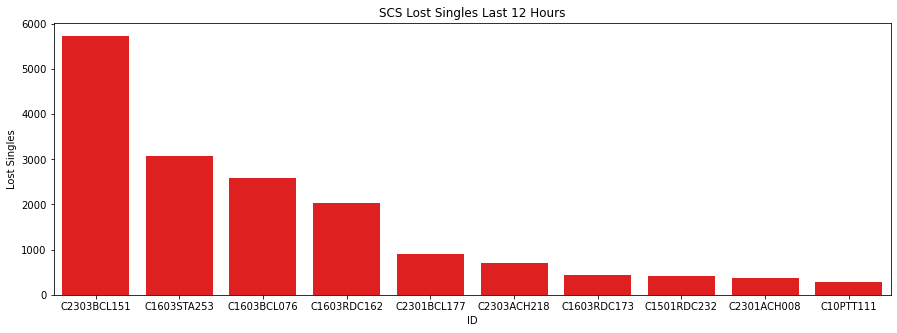

In [18]:
plt.figure(figsize=(15,5))
sns.barplot(y='SINGLES',x = 'ID',data = Total.sort_values(by='SINGLES',ascending=False).head(10),color = 'r')
plt.ylabel('Lost Singles')
plt.title('SCS Lost Singles Last 12 Hours')

In [ ]:
PTT081 = Output[['Asset Code','PTT081']].groupby('Asset Code').sum().reset_index()

In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(y='PTT081',x = 'Asset Code',data = PTT081.sort_values(by='PTT081',ascending=False).head(5),color = 'r')
plt.ylabel('Lost Singles')
plt.title('PTT081 Lost Singles Last 12 Hours')

In [20]:
Total_colour = Output[['BLUEGREY','SINGLES']].groupby('BLUEGREY').sum().reset_index()

Text(0.5, 1.0, 'SCS Lost Singles Last 12 Hours')

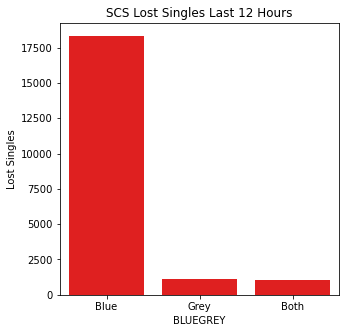

In [21]:
plt.figure(figsize=(5,5))
sns.barplot(y='SINGLES',x = 'BLUEGREY',data = Total_colour.sort_values(by='SINGLES',ascending=False),color = 'r')
plt.ylabel('Lost Singles')
plt.title('SCS Lost Singles Last 12 Hours')

In [ ]:
Total_colour

In [ ]:
sns.lmplot(x='log_totes', y='Availability', data=df, line_kws={"color": "red"})
plt.xlim(0, 5)

In [ ]:
sns.lmplot(x='TOTES', y='Availability', data=df_week, line_kws={"color": "red"})

In [ ]:
ax = sns.regplot(x="TOTES", y="Availability", data=df_week,
x_estimator=np.mean, logx=True, line_kws={"color": "red"})
plt.ylim(0,1)

In [ ]:
sns.lmplot(x='log_totes', y='Availability', data=df_week, line_kws={"color": "red"})
plt.xlim(0, 5)

In [ ]:
Shift = [0,0,0,10,10,10,20,20,20]
Weights = [[1],[0.7,0.3],[0.7,0.2,0.1],[1],[0.7,0.3],[0.7,0.2,0.1],[1],[0.7,0.3],[0.7,0.2,0.1]]

In [ ]:
Weights[8]

In [ ]:
y

In [ ]:
at

In [ ]:
fa_floor

In [ ]:
df.drop(['Availability','Blue Tote Loss','Grey Tote Loss','timestamp'],axis=1)

In [ ]:
Outputs = {0.5:'Number One',0.4:'Number Two',-1.4:'Number 3'}

In [ ]:
 Output = Outputs[max(k for k, v in Outputs.items())]

In [ ]:
Outputs[0.456]='Numbers 4'

In [ ]:
Outputs

In [ ]:
print('Selected R2:', max(k for k, v in Outputs.items()))

In [ ]:
fa_floor = feat.floor_shift_time_fa(fa, shift=10)

df,fa_PTT = feat.create_PTT_df(fa_floor,at,av,weights=[0.7,0.2,0.1])
df = feat.log_totes(df) 
df_2week = df[df['timestamp']>end_time - pd.to_timedelta(14, unit='D')]
X,y = md.gen_feat_var(df_2week,target = 'Availability', features = ['Totes','Faults'])
X_train, X_test, y_train, y_test = md.split(X,y,split_options = {'test_size': 0.3,
                                                                    'random_state': None})

R2_cv,R2_OOS,Coeff = md.run_OLS(X_train = X_train,y_train = y_train,X_test = X_test,y_test=y_test, n = 30)

Output = rs.create_output(fa_PTT,Coeff,end_time,speed = speed, picker_present = picker_present, availability = availability)

In [ ]:
R2_OOS

In [26]:
fa_floor

,Alert ID,Number,Alert,timestamp,PLC,Desk,Duration,Fault ID,Asset Code,Tote Colour,Loop,Suffix,Pick Station,PLCN,Quadrant,MODULE,Alert Type,Original_timestamp
0,25977.0,186939.0,C23: C2301RDC061 061AQ1 roller motor unit fault,2020-11-20 00:00:00,C23,P01,1.0,3429.0,C2301RDC061,Blue,Outside,C2301,False,23.0,0.0,NaN,Fault,2020-11-20 00:15:09
1,25764.0,100405.0,C12: C12PTT151_ external unit fault,2020-11-20 00:00:00,C12,Z,1.0,3611.0,C12PTT151,Both,NaN,NaN,PTT151,12.0,3.0,15,Fault,2020-11-20 00:39:18
2,25744.0,434821.0,SCS204: load device: slit sensor B11 X:41 Y:8 ...,2020-11-20 00:00:00,SCSM20,SCS204,25.0,5100.0,SCS204,Grey,carousel,SCSM20,False,0.0,4.0,20,Fault,2020-11-20 00:43:33
3,26046.0,99766.0,C12: C1202STA097 097B12 occupancy sensor fault,2020-11-20 00:00:00,C12,P02,12.0,3416.0,C1202STA097,Grey,Module,C1202,False,12.0,3.0,14,Fault,2020-11-20 00:05:15
4,25974.0,431169.0,SCS184: main switch is OFF in automaticmode X:...,2020-11-20 00:00:00,SCSM18,SCS184,2676.0,5032.0,SCS184,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault,2020-11-20 00:15:24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130253,151293.0,130631.0,C16: C1602ACL040 040QM11 motor circuit breaker...,2020-12-10 00:00:00,C16,P02,3600.0,3430.0,C1602ACL040,Blue,NaN,NaN,False,16.0,0.0,NaN,Fault,2020-12-10 00:00:00
130254,151293.0,130631.0,C16: C1602ACL040 040QM11 motor circuit breaker...,2020-12-10 01:00:00,C16,P02,3600.0,3430.0,C1602ACL040,Blue,NaN,NaN,False,16.0,0.0,NaN,Fault,2020-12-10 01:00:00
130255,145956.0,188345.0,C23: C2303BCL151 151B54 sensor fault,2020-12-10 01:00:00,C23,P03,3293.0,3428.0,C2303BCL151,Blue,Outside,C2303,False,23.0,0.0,NaN,Fault,2020-12-10 01:00:00
130256,151293.0,130631.0,C16: C1602ACL040 040QM11 motor circuit breaker...,2020-12-10 02:00:00,C16,P02,3600.0,3430.0,C1602ACL040,Blue,NaN,NaN,False,16.0,0.0,NaN,Fault,2020-12-10 02:00:00


In [18]:
print(fa.loc[fa['Area'].isnull() & fa['Desk'] == 'Z', 'Area'])

Series([], Name: Area, dtype: object)


In [17]:
fa['Area'].isnull() & fa['Desk'] == 'Z' 

44089     False
45795     False
123648    False
45796     False
45797     False
          ...  
123729    False
168381    False
48767     False
123486    False
123066    False
Length: 124976, dtype: bool

In [7]:
fa

,Alert ID,Number,Alert,timestamp,PLC,Desk,Duration,Fault ID,Asset Code,Area,Tote Colour,Loop,Suffix,Pick Station,PLCN,Quadrant,MODULE,Alert Type
44089,15447.0,186939.0,C23: C2301RDC061 061AQ1 roller motor unit fault,2020-11-21 05:41:29,C23,P01,1.0,3429.0,C2301RDC061,C23,Blue,Outside,C2301,False,23.0,0.0,NaN,Fault
45795,25176.0,186939.0,C23: C2301RDC061 061AQ1 roller motor unit fault,2020-11-20 02:09:45,C23,P01,1.0,3429.0,C2301RDC061,C23,Blue,Outside,C2301,False,23.0,0.0,NaN,Fault
123648,145475.0,130423.0,C16: C1601ACH027 027QM11 motor circuit breaker...,2020-12-09 22:26:12,C16,P01,1.0,3430.0,C1601ACH027,C16,Blue,NaN,NaN,False,16.0,0.0,NaN,Fault
45796,25187.0,186939.0,C23: C2301RDC061 061AQ1 roller motor unit fault,2020-11-20 02:07:29,C23,P01,1.0,3429.0,C2301RDC061,C23,Blue,Outside,C2301,False,23.0,0.0,NaN,Fault
45797,25193.0,186939.0,C23: C2301RDC061 061AQ1 roller motor unit fault,2020-11-20 02:06:22,C23,P01,1.0,3429.0,C2301RDC061,C23,Blue,Outside,C2301,False,23.0,0.0,NaN,Fault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123729,151293.0,130631.0,C16: C1602ACL040 040QM11 motor circuit breaker...,2020-12-09 06:38:52,C16,P02,74254.0,3430.0,C1602ACL040,C16,Blue,NaN,NaN,False,16.0,0.0,NaN,Fault
168381,22650.0,127995.0,C15: C15+FD1 Fire Alarm system alarm,2020-11-20 10:32:20,C15,Z,75917.0,3242.0,C15,C15,Blue,NaN,NaN,False,15.0,0.0,NaN,Fault
48767,126174.0,188777.0,C23: C2303RDC194 194AQ1 roller motor unit fault,2020-12-06 08:03:18,C23,P03,76318.0,3429.0,C2303RDC194,C23,Blue,Outside,C2303,False,23.0,0.0,NaN,Fault
123486,126185.0,186559.0,C23: C2303BCL038 038QM11 motor circuit breaker...,2020-12-06 08:03:15,C23,P03,76322.0,3430.0,C2303BCL038,C23,Blue,Outside,C2303,False,23.0,0.0,NaN,Fault
